# TIC Simulations - Teichman et al. 2024

This Jupyter notebook includes the code for running the simulations presented in Figures 6 and 7 of Teichman et al. 2024. 
This model is based upon the Toggle-Inhibitor with Competition (TIC) model presented in Karin et al. 2023, with added parameters and assumptions to help in simulating the effects of temperature perception on transgenerational inheritance of small RNAs. 

### Import required libraries and define helper functions.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy
from joblib import Parallel, delayed
from numba import njit
%matplotlib inline
import matplotlib_inline
import seaborn as sns
from typing import Literal
from collections import namedtuple
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
SimulationParams = namedtuple('SimulationParams', [
    'V_crit',
    'V_tot',  # Total silencing capacity of the worm
    'lambda_',  # new silencing events per generation
    'n',  # Hill coefficient (cooperativity) for g
    'k1',
    'k2',
    'k3',
    'psi',  # Rate of H3K9me3 deposition
    'gamma1',
    'gamma2',
    'I',  # RNAi trigger strength
    'sigma1',  # Noise in g
    'sigma2',  # Noise in h
    'dt',  # Time step in hours
    'generation_length'  # Generation length in hours
])

In [3]:
def build_base_graph(title: str, going_up: bool = True, n_generations: int = 8) -> tuple[plt.Figure, plt.Axes]:
    """
    Utility function that generates the basic figure/axes layout for time-series simulations. 
    
    :param title: The title of the figure
    :param going_up: Whether the simulation is going up or down in temperature. \
    If True, the first half of the graph will be blue (low temperature), and the second half red (high temperature). \
    If False, the first half will be red and the second half blue.
    :param n_generations: The number of generations to simulate. This is used to set the x-axis limits.
    """
    fig, axes = plt.subplots(1, 2, figsize=[6.4 * 2, 4.8])
    fig.suptitle(title)
    for this_ax in axes:
        this_ax.set_xlim(-0.5, n_generations - 0.5)
        this_ax.set_ylim(0, 100)
        if isinstance(going_up, bool):
            fc1, fc2 = ('b', 'r') if going_up else ('r', 'b')
            this_ax.axvspan(-0.5, 0.5, facecolor=fc1, alpha=0.08)
            this_ax.axvspan(0.5, n_generations - 0.5, facecolor=fc2, alpha=0.08)
    sns.despine()
    return fig, axes

In [4]:
@njit
def est_silencing(g: np.ndarray, h: np.ndarray, gene_index: int) -> float:
    """
    estimate the silencing level of a gene based on the g (small RNAs) and h (H3K9me3) values. 
    
    :param g: array of small RNA levels for each gene
    :param h: array of H3K9me3 levels for each gene
    :param gene_index: index of the gene to estimate silencing for
    """
    return np.sqrt(g[gene_index] ** 2 + h[gene_index] ** 2)


@njit
def is_silenced(g, h, gene_index, threshold=0.5):
    """
    Check if a gene is silenced based on the g and h values. \
    Returns True if the silencing level is above the threshold, False otherwise.
    
    :param g: array of small RNA levels for each gene
    :param h: array of H3K9me3 levels for each gene
    :param threshold: the silencing level threshold above which the gene is considered silenced. \
    Higher threshold values assume that silencing is harder to observe (only "strongly-silenced" worms actually appear silenced). 
    :param gene_index: index of the gene to estimate silencing for
    """
    return est_silencing(g, h, gene_index) > threshold


@njit
def update_silencing_core(step:int, g:np.ndarray, h:np.ndarray, num_genes:int, 
                          V_tot:float, arrival_rate:float, n:float, k1:float, k2:float, k3:float, psi:float,
                          gamma1:float, gamma2:float, sigma1:float, sigma2:float, dt:float, generation_length:int, chronic_silencing:float, I:float,
                          rnai_trigger_generation:int, rnai_trigger_gene:int, pre_run_gens:int, gfp_targeting_factor:float):
    """
    Core function that updates the silencing levels of all genes in each step of the simulation. 
    
    :param step: 
    :param g: 
    :param h: 
    :param num_genes: 
    :param V_tot: 
    :param arrival_rate: 
    :param n: 
    :param k1: 
    :param k2: 
    :param k3: 
    :param psi: 
    :param gamma1: 
    :param gamma2: 
    :param sigma1: 
    :param sigma2: 
    :param dt: 
    :param generation_length: 
    :param chronic_silencing: 
    :param I: 
    :param rnai_trigger_generation: 
    :param rnai_trigger_gene: 
    :param pre_run_gens: 
    :param gfp_targeting_factor: 
    """
    current_time = step * dt
    num_new_silenced = np.random.poisson((arrival_rate * dt) / generation_length)
    unsilenced_indices = np.where(np.sqrt(g[1:] ** 2 + h[1:] ** 2) <= 0.5)[0]
    if current_time // generation_length > pre_run_gens:
        expanded_indices = np.concatenate((unsilenced_indices,
                                           np.repeat(0,
                                                     int(gfp_targeting_factor - 1) if 0 in unsilenced_indices else 0)))
    else:
        expanded_indices = unsilenced_indices
    new_silenced_indices = np.random.choice(expanded_indices, num_new_silenced, replace=False)

    cost = np.sum(g) + 1

    for i in range(num_genes):
        if chronic_silencing[i] != 0 and current_time // generation_length > pre_run_gens:
            v_scale = 1 + chronic_silencing[i]
        else:
            v_scale = 1

        dg = (v_scale * V_tot / cost) * (g[i] ** n / (k1 ** n + g[i] ** n)) * (k2 / (k2 + h[i])) - gamma1 * g[i]
        dh = psi * (g[i] / (k3 + g[i])) - gamma2 * h[i]
        # Apply RNAi trigger
        if i == rnai_trigger_gene and current_time // generation_length == rnai_trigger_generation + pre_run_gens:
            dg += I

        g[i] += dt * dg + sigma1 * g[i] * np.random.normal() * np.sqrt(dt)
        h[i] += dt * dh + sigma2 * h[i] * np.random.normal() * np.sqrt(dt)

        g[i] = max(g[i], 0)
        h[i] = max(h[i], 0)

        if i in new_silenced_indices:
            g[i] = 3


@njit
def simulate_core(total_time:int, num_genes:int, gfp_index:int, rnai_trigger_generation:int, rnai_trigger_gene:int,
                  initial_silenced:int, V_tot:float, arrival_rate:float, n:float, k1:float, k2:float, k3:float, psi:float, 
                  gamma1:float, gamma2:float, sigma1:float, sigma2:float, dt:float,
                  generation_length:float, I:float, chronic_silencing, initial_silencing, pre_run_gens:int, gfp_targeting_factor:float,
                  updated_vtot:float, vtot_trigger_generation:int, updated_psi:float, psi_trigger_generation:int):
    """
    Core simulation function that runs the TIC model for the specified duration. 
    
    :param total_time: 
    :param num_genes: 
    :param gfp_index: 
    :param rnai_trigger_generation: 
    :param rnai_trigger_gene: 
    :param initial_silenced: 
    :param V_tot: 
    :param arrival_rate: 
    :param n: 
    :param k1: 
    :param k2: 
    :param k3: 
    :param psi: 
    :param gamma1: 
    :param gamma2: 
    :param sigma1: 
    :param sigma2: 
    :param dt: 
    :param generation_length: 
    :param I: 
    :param chronic_silencing: 
    :param initial_silencing: 
    :param pre_run_gens: 
    :param gfp_targeting_factor: 
    :param updated_vtot: 
    :param vtot_trigger_generation: 
    :param updated_psi: 
    :param psi_trigger_generation: 
    """
    g = np.zeros(num_genes)
    h = np.zeros(num_genes)

    # Initialize some genes to be silenced
    if initial_silenced > 0:
        unsilenced_indices = np.where((g == 0) & (h == 0))[0]
        silenced_indices = np.random.choice(unsilenced_indices, size=initial_silenced, replace=False)
        g[silenced_indices] = 3

    num_steps = int(total_time / dt)

    gfp_silencing = np.zeros(num_steps)
    g_trajectory = np.zeros(num_steps)
    h_trajectory = np.zeros(num_steps)

    for step in range(num_steps):
        current_time = step * dt
        if vtot_trigger_generation is not None and current_time // generation_length >= pre_run_gens + vtot_trigger_generation:
            V_tot = updated_vtot
        if psi_trigger_generation is not None and current_time // generation_length >= pre_run_gens + psi_trigger_generation:
            psi = updated_psi

        if current_time // generation_length == pre_run_gens:
            # Set initial silencing levels for specific genes
            g[gfp_index] = initial_silencing[0]
            h[gfp_index] = initial_silencing[1]

        update_silencing_core(step, g, h, num_genes, V_tot, arrival_rate, n, k1, k2, k3, psi,
                              gamma1, gamma2, sigma1, sigma2, dt, generation_length, chronic_silencing, I,
                              rnai_trigger_generation, rnai_trigger_gene, pre_run_gens, gfp_targeting_factor)

        gfp_silencing[step] = est_silencing(g, h, gfp_index)
        g_trajectory[step] = g[gfp_index]
        h_trajectory[step] = h[gfp_index]

    return gfp_silencing, g_trajectory, h_trajectory

In [5]:
class TICModel:
    """
    A class representing the TIC model for gene silencing. 
    To run a TIC simulation, create an instance of this class, set the desired parameters/options, \
    and call either the "plot_phase_space" or "plot_silencing_timecourse" methods. 
    """

    def __init__(self, num_genes: int, gfp_index: int, params: SimulationParams, pre_run_gens=2):
        """
        Initialize the TICModel instance with the specified parameters.
        
        :param num_genes: number of genes to be simulated, alongside the GFP reporter gene. \
        Higher values increase running time of the simulation. 
        :param gfp_index: index of the GFP reporter gene in the gene array. This will be used to track its silencing levels later on. 
        :param params: a SimulationParams (tuple) of simulation parameters
        :param pre_run_gens: number of generations to simulate before the actual experiment \
        (e.g. temperature transition, RNAi triggers, and tracking of silencing levels) begins. 
        """
        self.num_genes = num_genes
        self.gfp_index = gfp_index
        self.params = params._asdict()
        self.g = np.zeros(num_genes)
        self.h = np.zeros(num_genes)
        self.rnai_trigger_gene = None
        self.rnai_trigger_generation = -1
        self.chronic_silencing = np.zeros(num_genes)
        self.initial_silencing = np.zeros(2)
        self.pre_run_gens = pre_run_gens
        self.gfp_targeting_factor = 1
        self.updated_vtot = None
        self.vtot_trigger_generation = None
        self.updated_psi = -1
        self.psi_trigger_generation = None

    def apply_rnai_trigger(self, gene_index: int, trigger_generation: int):
        """
        Apply a one-time RNAi trigger against a specific gene at a specific generation.
        
        :param gene_index: index of the gene to apply RNAi to. 
        :param trigger_generation: the generation number of the experiment to apply the trigger at. 

        """
        self.rnai_trigger_gene = gene_index
        self.rnai_trigger_generation = trigger_generation

    def set_v_tot_change(self, value: float, trigger_generation: int):
        """
        Apply a change in the Vtot simulation parameter at a specific generation. \
        This is used to simulate a change in temperature or other conditions that affect the total silencing capacity of the worm. 
        
        :param value: new value for Vtot. 
        :param trigger_generation: the generation number of the experiment to apply the change at. 
        """
        self.updated_vtot = value
        self.vtot_trigger_generation = trigger_generation

    def set_psi_change(self, value: float, trigger_generation: int):
        """
        Apply a change in the psi simulation parameter at a specific generation. \
        This is used to simulate a change in temperature or other conditions that affect the deposition of H3K9me3 in the worm. \
        Note that this feature was not used in the simulations presented in Teichman et al. 2024. 
        
        :param value: new value for psi. 
        :param trigger_generation: the generation number of the experiment to apply the change at. 
        """
        self.updated_psi = value
        self.psi_trigger_generation = trigger_generation

    def set_chronic_silencing(self, gene_index: int, strength: float):
        """
        Set a chronic silencing level for a specific gene. \
        This will cause the gene to accumulate small RNAs to a higher degree in a stable manner. \
        Note that this feature was not used in the simulations presented in Teichman et al. 2024. 

        :param gene_index: index of the gene to apply chronic silencing to. 
        :param strength: strength of the chronic silencing trigger. 
        """
        self.chronic_silencing[gene_index] = strength

    def set_initial_silencing_gfp(self, g_value: float, h_value: float):
        """
        Set the initial silencing level of the GFP reporter. This will apply to the first generation of the simulation \
        (meaning, after the pre-run generations have finished). 
        :param g_value: initial level of small RNAs. 
        :param h_value: initial levels of H3K9me3. 
        """
        self.initial_silencing[0] = g_value
        self.initial_silencing[1] = h_value

    def set_gfp_targeting_factor(self, factor: float = 1):
        """
        Set the GFP targeting factor, which determines the likelihood of the GFP reporter gene \
        being the target of a stochastic silencing event, compared to all other genes. 
        :param factor: the GFP targeting factor. a value of X means GFP is X times more likely to be targeted by stochastic silencing events, \
        compared to any other gene in the simulation. 
        """
        self.gfp_targeting_factor = factor

    def simulate(self, total_time: int, initial_silenced: int = 0, track_silencing: bool = True):
        """
        Run a simulation of the TIC model for the specified duration, returning the small RNA and H3K9me3 levels of all genes over time. 
        :param total_time: total duration of the simulation. 
        :param initial_silenced: number of genes to initialize as silenced (g=3, h=0). 
        :param track_silencing: if True, track the silencing of the GFP reporter over time and return it. 
        """

        V_tot = self.params['V_tot']
        arrival_rate = self.params['lambda_']
        n = self.params['n']
        k1 = self.params['k1']
        k2 = self.params['k2']
        k3 = self.params['k3']
        psi = self.params['psi']
        gamma1 = self.params['gamma1']
        gamma2 = self.params['gamma2']
        I = self.params['I']
        sigma1 = self.params['sigma1']
        sigma2 = self.params['sigma2']
        dt = self.params['dt']
        generation_length = self.params['generation_length']

        g, h, sil = simulate_core(
            total_time,
            self.num_genes,
            self.gfp_index,
            self.rnai_trigger_generation,
            self.rnai_trigger_gene,
            initial_silenced,
            V_tot,
            arrival_rate,
            n,
            k1,
            k2,
            k3,
            psi,
            gamma1,
            gamma2,
            sigma1,
            sigma2,
            dt,
            generation_length,
            I,
            self.chronic_silencing,
            self.initial_silencing,
            self.pre_run_gens,
            self.gfp_targeting_factor,
            self.updated_vtot,
            self.vtot_trigger_generation,
            self.updated_psi,
            self.psi_trigger_generation
        )
        if track_silencing:
            return g, h, sil
        return g, h

    def plot_phase_space(self, num_generations: int, num_trajectories: int = 1, initial_silenced: int = 0):
        """
        Simulate and plot the phase space of the GFP reporter gene, showing the relationship between small RNAs and H3K9me3 levels. 
        
        :param num_generations: number of generations to run the simulation for. 
        :param num_trajectories: number of trajectories (e.g. independent replicates of the experiment) to run. 
        :param initial_silenced: number of genes to initialize as silenced (g=3, h=0). 
        """
        num_generations += self.pre_run_gens
        total_time = num_generations * self.params['generation_length']
        pre_run_points = int(self.pre_run_gens * self.params['generation_length'] / self.params['dt'])
        fig, ax = plt.subplots()
    
        def simulate_trajectory(_):
            _, g_trajectory, h_trajectory = self.simulate(total_time, initial_silenced=initial_silenced)
            return g_trajectory[pre_run_points:], h_trajectory[pre_run_points:]
        
        
        trajectories = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_trajectories))
        
        # for i in range(num_trajectories):
        #     _, g_trajectory, h_trajectory = self.simulate(total_time, initial_silenced=initial_silenced)
        #     ax.plot(h_trajectory[pre_run_points:], g_trajectory[pre_run_points:],
        #             '-o', alpha=0.7, markersize=3, label=f'Trajectory {i + 1}')
        
        for g_trajectory, h_trajectory in trajectories:
            ax.plot(h_trajectory, g_trajectory, '-o', alpha=0.7, markersize=3)
        
        ax.set_xlabel('H3K9me3')
        ax.set_ylabel('siRNAs')
        ax.set_title(f'Phase Space Plot - Gene #{self.gfp_index}')
        ax.set_xlim([0, 1.5])
        ax.set_ylim([0, 9])
        plt.show()

    def plot_silencing_timecourse(self, num_generations: int, num_trajectories: int = 15, threshold: float = 1,
                                  initial_silenced: int = 0, n_per_trajectory: int = 25, ax=None, color: str = 'green',
                                  title: str = 'Simulation', error_bars: Literal['std', 'sem', None] = None):
        """
        Simulate and plot GFP silencing over generations, showing the percentage of worms expressing GFP over time. 
        
        :param num_generations: number of generations to run the simulation for.
        :param num_trajectories: number of trajectories (e.g. independent replicates of the experiment) to run.
        :param threshold: the silencing threshold above which GFP is considered silenced.
        :param initial_silenced: number of genes to initialize as silenced (g=3, h=0).
        :param n_per_trajectory: number of worms to use as progenitors at each generation of each trajectory. \
        Each trajetcory will begin with this number of 'pure' worm lineages (derived from a single mother with its own stochastic silencing state/events), \
        and the same number of mothers will be randomly selected at each generation to yield the next generation. \
        This progressive bottleneck simulates what occurs in a real experiment, where a small number of worms are used to start each generation. \
        A smaller number of worms will lead to a "bottleneck" inheritance effect. 
        :param ax: optionally, provide a tuple of axes to plot the timecourse on.
        :param color: color to use for the plot.
        :param title: title for the plot
        :param error_bars: type of error bars to plot on the summary graph. Options are 'std', 'sem', or None.
        """
        num_generations += self.pre_run_gens
        total_time = num_generations * self.params['generation_length']
        ascending = None if self.updated_vtot is None else self.params['V_tot'] > self.updated_vtot
        # get base axes
        if ax is None:
            fig, (ax1, ax2) = build_base_graph(title, ascending, num_generations - self.pre_run_gens)
        else:
            ax1, ax2 = ax
        
        # simulate individual trajectories
        def simulate_trajectory(traj):
            silencing_trajectories = []
            for i in range(n_per_trajectory):
                gfp_silencing, _, _ = self.simulate(total_time, initial_silenced=initial_silenced)
                silencing_trajectories.append(gfp_silencing)

            expressing_percentages_traj = np.zeros(num_generations - self.pre_run_gens)
            # for each generation of the experiment, "propagate" `n_per_trajectory` worms to the next generation, and calculate the new probabilities 
            # of picking progenitors of each original "pure lineage"
            p = [1 / n_per_trajectory] * n_per_trajectory
            for generation in range(num_generations - self.pre_run_gens):
                this_timepoint = int(
                    (generation + 1 + self.pre_run_gens) * self.params['generation_length'] / self.params['dt']) - 1
                this_timepoint_start = this_timepoint - int(0.1 * self.params['generation_length'] / self.params['dt'])
                chosen = np.random.choice(np.arange(n_per_trajectory), size=n_per_trajectory, replace=True, p=p)
                p = [(chosen == i).sum() / n_per_trajectory for i in range(n_per_trajectory)]
                for c in chosen:
                    expressing_percentages_traj[generation] += np.mean(
                        silencing_trajectories[c][this_timepoint_start:this_timepoint + 1]) <= threshold

            return expressing_percentages_traj

        expressing_percentages = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(traj) for traj in range(num_trajectories))
        expressing_percentages = np.array(expressing_percentages).T
        
        # generate trendline plot (left axes)
        expressing_percentages = 100 * expressing_percentages / n_per_trajectory
        expressing_mean = expressing_percentages.mean(axis=1)
        ax1.plot(range(num_generations - self.pre_run_gens), expressing_mean, '-o', markersize=5, color=color)
        ax1.set_title('Averaged replicates')
        ax2.set_title('Individual replicates')
        # generate error bars
        if error_bars == 'sem':
            yerr = scipy.stats.sem(expressing_percentages, axis=1)
        elif error_bars == 'std':
            yerr = np.std(expressing_percentages, axis=1)
        else:
            yerr = None
        ax1.errorbar(range(num_generations - self.pre_run_gens), expressing_mean, yerr=yerr, capsize=5, linewidth=2, color=color)

        # generate individual trajectories plot (right axes)
        for exp in range(num_trajectories):
            ax2.plot(range(num_generations - self.pre_run_gens), expressing_percentages[:, exp], '-o', alpha=0.5,
                     color=color)
        # set axes limits, labels, and ticks
        for this_ax in [ax1, ax2]:
            this_ax.set_ylim([0, 100])
            this_ax.set_xlabel('Generations')
            this_ax.set_xticks(range(num_generations - self.pre_run_gens))
            if self.rnai_trigger_gene is not None:
                this_ax.set_xticklabels(
                    ['P-1', 'P0'] + [f"F{i + 1}" for i in range(num_generations - self.pre_run_gens - 2)])
            else:
                this_ax.set_xticklabels(['P0'] + [f"F{i + 1}" for i in range(num_generations - self.pre_run_gens - 1)])
            this_ax.set_ylabel('Expressing Worms (%)')
            this_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
            this_ax.set_yticks(list(range(0, 110, 10)))

        plt.tight_layout()
        return ax1, ax2

# Simulated temperature-dependent silencing experiments

In [6]:
# Define model parameters for temperature-dependent silencing experiments
params_20c = SimulationParams(
    V_crit=0.56,
    V_tot=200,
    lambda_=20,
    n=3,
    k1=2,
    k2=2,
    k3=0.1,
    psi=0.1,
    gamma1=0.1,
    gamma2=0.1,
    I=0.07,
    sigma1=0.02,
    sigma2=0.02,
    dt=2,
    generation_length=84)

params_25c = SimulationParams(
    V_crit=0.56,
    V_tot=100, # Reduced V_tot to simulate higher temperature
    lambda_=20,
    n=3,
    k1=2,
    k2=2,
    k3=0.1,
    psi=0.1,
    gamma1=0.1,
    gamma2=0.1,
    I=0.07,
    sigma1=0.02,
    sigma2=0.02,
    dt=2,
    generation_length=84)

## Experiment #1: Accumulation of silencing when transitioning from a high (25°C) to a low (20°C) temperature

In [7]:
# Create an instance of the TICModel
num_genes = 1000
gfp_index = 0
init_sil = int(params_25c.V_tot // params_25c.V_crit)
model2 = TICModel(num_genes, gfp_index, params_25c, pre_run_gens=5)

model2.set_gfp_targeting_factor(20)
model2.set_v_tot_change(250, 1)

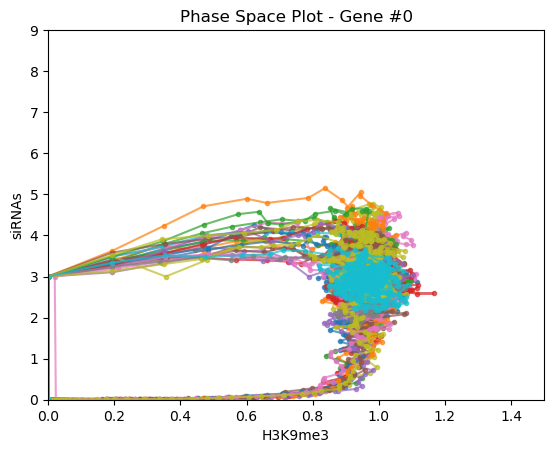

In [8]:
# Simulate and plot the phase space for the GFP reporter gene
num_generations_phase = 15
num_trajectories_phase = 20
model2.plot_phase_space(num_generations_phase, num_trajectories_phase, initial_silenced=0)

(<Axes: title={'center': 'Averaged replicates'}, xlabel='Generations', ylabel='Expressing Worms (%)'>,
 <Axes: title={'center': 'Individual replicates'}, xlabel='Generations', ylabel='Expressing Worms (%)'>)

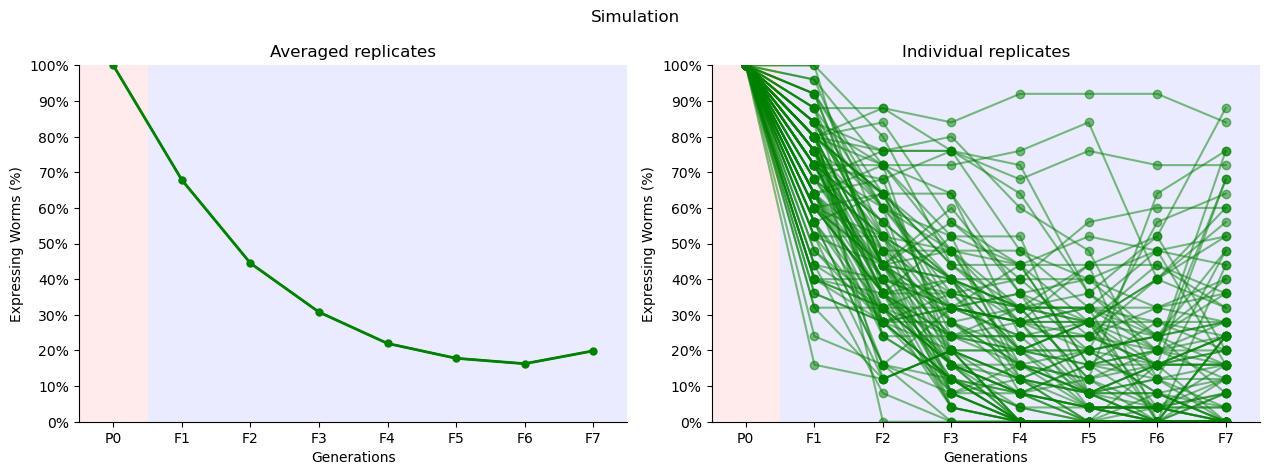

In [9]:
# Simulate and plot the silencing timecourse for the GFP reporter gene
num_generations_timecourse = 8
num_trajectories_timecourse = 100
model2.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1, initial_silenced=init_sil)

## Experiment 2: Rapid loss of silencing when transitioning from a low (20°C) to a high (25°C) temperature

In [10]:
# Create an instance of the TICModel
model3 = TICModel(num_genes, gfp_index, params_20c, pre_run_gens=5)
model3.set_initial_silencing_gfp(3, 1)
model3.set_v_tot_change(100, 1)

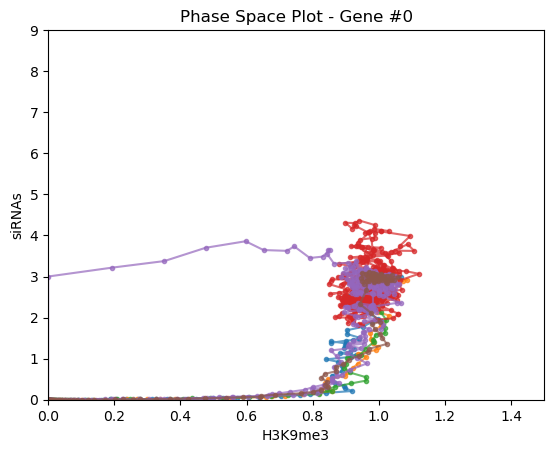

In [11]:
# Simulate and plot the phase space for the GFP reporter gene
num_generations_phase = 10
num_trajectories_phase = 6
model3.plot_phase_space(num_generations_phase, num_trajectories_phase, initial_silenced=init_sil)

(<Axes: title={'center': 'Averaged replicates'}, xlabel='Generations', ylabel='Expressing Worms (%)'>,
 <Axes: title={'center': 'Individual replicates'}, xlabel='Generations', ylabel='Expressing Worms (%)'>)

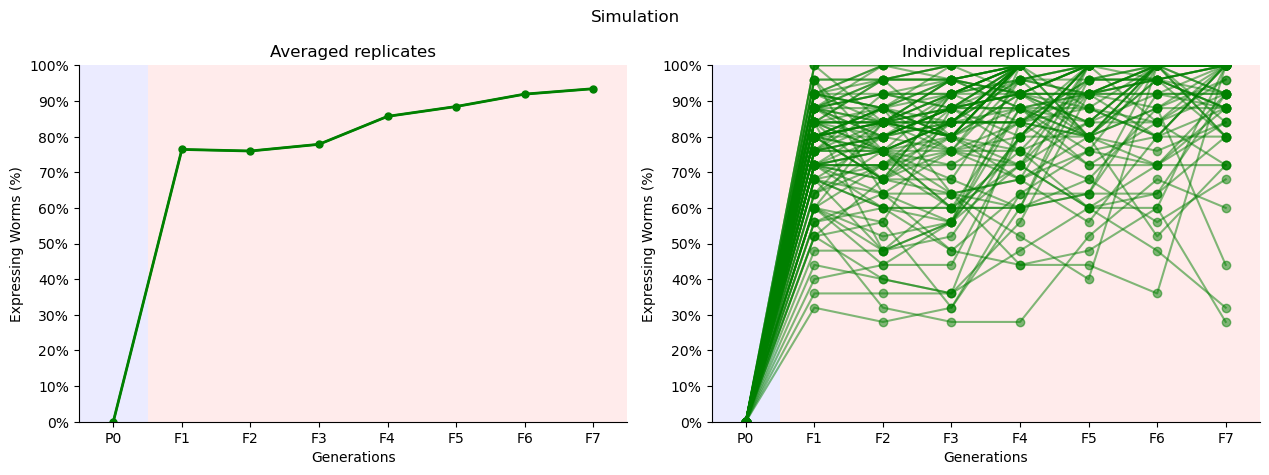

In [12]:
# Simulate and plot the silencing timecourse for the GFP reporter gene
num_generations_timecourse = 8
num_trajectories_timecourse = 100
model3.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1, initial_silenced=init_sil)

## Experiment #3: Accumulation of silencing in sensation mutants, when transitioning from a high (25°C) to a low (20°C) temperature (Figure 6B)

C:\Users\Guy_Teichman\AppData\Local\Temp\ipykernel_19576\2760359348.py:279: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


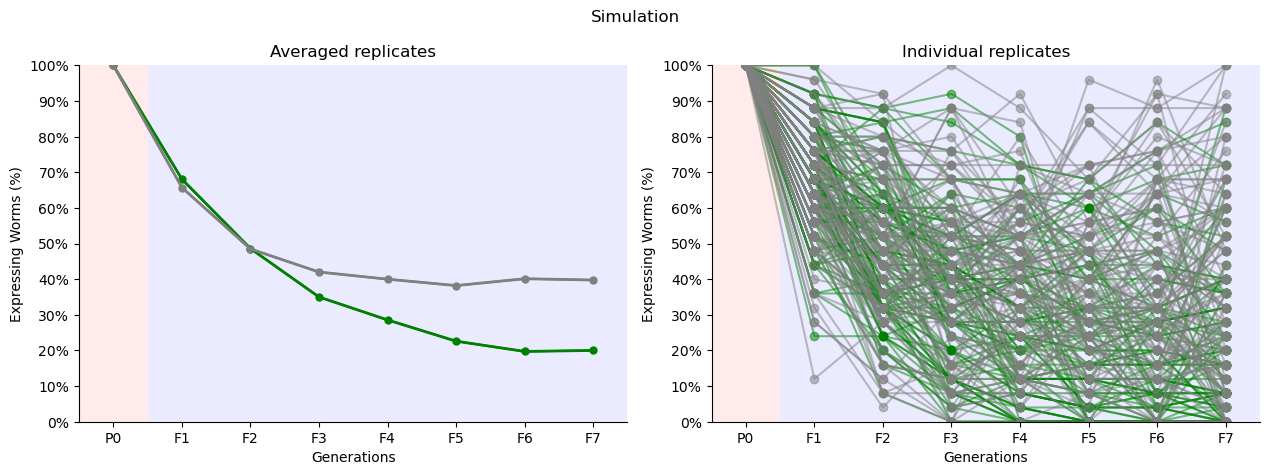

In [16]:
num_genes = 1000
model6 = TICModel(num_genes, gfp_index, params_25c, pre_run_gens=3)
model6.set_gfp_targeting_factor(20)
model6.set_v_tot_change(100, 1)
# Simulate and plot the silencing timecourse for the GFP reporter gene
num_generations_timecourse = 8
num_trajectories_timecourse = 100

init_sil = int(params_25c.V_tot // params_25c.V_crit)

ax_25to20 = model2.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1,
                                             initial_silenced=init_sil)
_ = model6.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1,
                                     initial_silenced=init_sil, ax=ax_25to20, color='grey')

## Experiment #4: Rapid loss of silencing in sensation mutants, when transitioning from a low (20°C) to a high (25°C) temperature (Figure 6C)

C:\Users\Guy_Teichman\AppData\Local\Temp\ipykernel_19576\2760359348.py:279: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


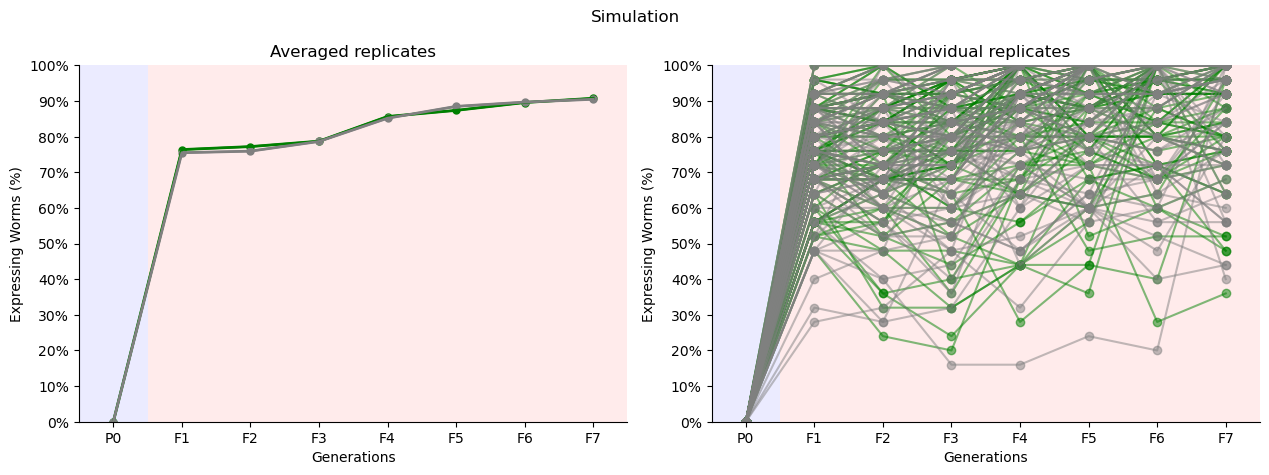

In [14]:
# Create an instance of the TICModel
model4_2 = TICModel(num_genes, gfp_index, params_20c, pre_run_gens=5)

# Apply a one-time RNAi trigger against GFP at generation 0
model4_2.set_gfp_targeting_factor(1)
model4_2.set_initial_silencing_gfp(3, 1)
model4_2.set_v_tot_change(100, 1)

# Simulate and plot the silencing timecourse for the GFP reporter gene
num_generations_timecourse = 8
num_trajectories_timecourse = 100
ax_20to25 = model3.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1,
                                             initial_silenced=init_sil)
_ = model4_2.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1,
                                       initial_silenced=init_sil, ax=ax_20to25, color='grey')

## Experiment #5: High-variance phenotype in cmk-1 mutants, when transitioning from a low (20°C) to a high (25°C) temperature (Figure 6D)

C:\Users\Guy_Teichman\AppData\Local\Temp\ipykernel_19576\2760359348.py:279: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


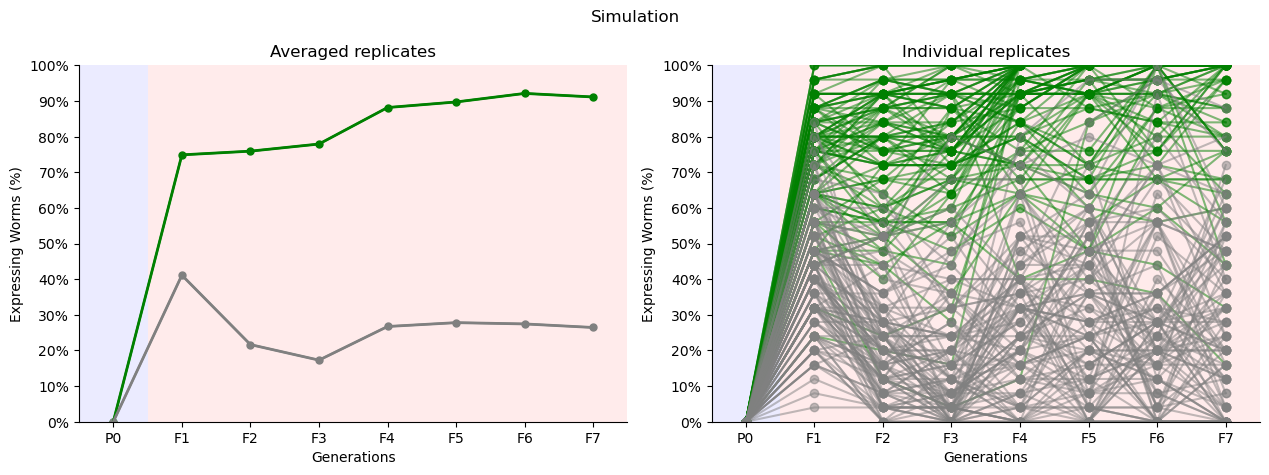

In [13]:
# Create an instance of the TICModel
model4 = TICModel(num_genes, gfp_index, params_20c, pre_run_gens=5)

# Apply a one-time RNAi trigger against GFP at generation 0
model4.set_gfp_targeting_factor(30)
model4.set_initial_silencing_gfp(3, 1)
model4.set_v_tot_change(100, 1)
model4.set_psi_change(0.1, 1)

# Simulate and plot the silencing timecourse for the GFP reporter gene
num_generations_timecourse = 8
num_trajectories_timecourse = 100
ax_20to25 = model3.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1,
                                             initial_silenced=init_sil)
_ = model4.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=1,
                                     initial_silenced=init_sil, ax=ax_20to25, color='grey')

## Simulated RNAi experiment - wild-type worms vs sensation mutants in 20°C (Figure 7A)

C:\Users\Guy_Teichman\AppData\Local\Temp\ipykernel_19576\2760359348.py:279: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


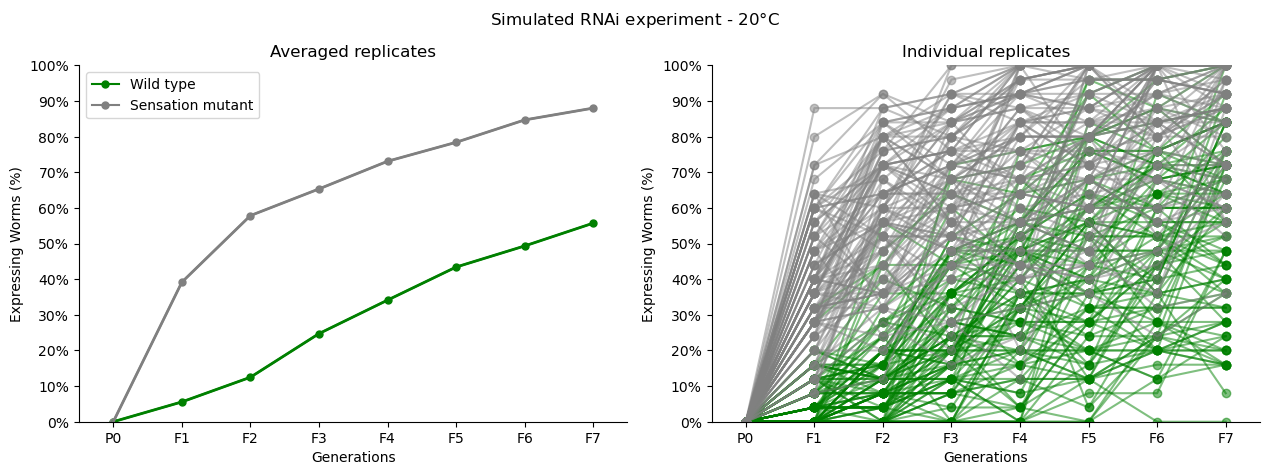

In [17]:
# Define model parameters
params = SimulationParams(
    V_crit=0.56,
    V_tot=250,
    lambda_=20,
    n=3,
    k1=2,
    k2=2,
    k3=0.1,
    psi=0.1,
    gamma1=0.1,
    gamma2=0.1,
    I=0.065,
    sigma1=0.02,
    sigma2=0.02,
    dt=2,
    generation_length=84)

num_genes = 1000
gfp_index = 0
num_generations_timecourse = 8
num_trajectories_timecourse = 100

# Create an instance of the TICModel
init_sil = int(params.V_tot // params.V_crit)
model = TICModel(num_genes, gfp_index, params, pre_run_gens=5)
# Apply a one-time RNAi trigger against GFP at generation 0
trigger_generation = 1
# model.apply_rnai_trigger(gfp_index, trigger_generation)
model.set_initial_silencing_gfp(2.5, 1)

params_mutant = SimulationParams(
    V_crit=0.56,
    V_tot=150,
    lambda_=20,
    n=3,
    k1=2,
    k2=2,
    k3=0.1,
    psi=0.1,
    gamma1=0.1,
    gamma2=0.1,
    I=0.065,
    sigma1=0.02,
    sigma2=0.02,
    dt=2,
    generation_length=84)

model_mutant = TICModel(num_genes, gfp_index, params_mutant, pre_run_gens=5)
# Set initial silencing level for GFP, simulating a one-time RNAi trigger
model_mutant.set_initial_silencing_gfp(2.5, 1)

ax_rnai = model.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=2.5,
                                          initial_silenced=init_sil)
_ = model_mutant.plot_silencing_timecourse(num_generations_timecourse, num_trajectories_timecourse, threshold=2.5,
                                           initial_silenced=init_sil, ax=ax_rnai, color='grey')
plt.suptitle(r'Simulated RNAi experiment - $20\degree$C')
ax_rnai[0].legend(['Wild type', 'Sensation mutant'])